In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from tqdm import tqdm

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [3]:
def remap_prob(p, epsilon=0.1):
    if p == 0:
        out = epsilon
    elif p == 100:
        out = 100 - epsilon
    else:
        out = p
    return out/100

In [4]:
def compare_tpr_mcnemar(
    df, y_true, a, b,
    alternative='greater',   # "greater" tests if a > b
    n_boot=0,
    random_state=0
):
    # Restrict to ground-truth positives (TPR compares recall on positives)
    pos = df[df[y_true] == 1]

    # TPRs
    tpr_a = pos[a].mean()
    tpr_b = pos[b].mean()
    diff  = tpr_a - tpr_b

    # Paired contingency on positives
    both_hits = ((pos[a] == 1) & (pos[b] == 1)).sum()
    only_a    = ((pos[a] == 1) & (pos[b] == 0)).sum()  # counts where a is "better"
    only_b    = ((pos[a] == 0) & (pos[b] == 1)).sum()  # counts where b is "better"
    neither   = ((pos[a] == 0) & (pos[b] == 0)).sum()

    # Exact McNemar p-value (binomial on discordant pairs)
    discordant = only_a + only_b
    if discordant > 0:
        pval = binomtest(only_a, discordant, p=0.5, alternative=alternative).pvalue
    else:
        pval = 1.0  # no discordant pairs → no evidence of difference

    result = {
        'n_positives': int(len(pos)),
        'tpr_DefensePredictor': float(tpr_a),
        'tpr_HHblits': float(tpr_b),
        'tpr_diff_(DP - HHblits)': float(diff),
        'both_hits': int(both_hits),
        'only_DP_hits': int(only_a),
        'only_HHblits_hits': int(only_b),
        'neither_hits': int(neither),
        'mcnemar_pvalue_one_sided': float(pval),
        'alternative': alternative,
    }

    # Optional paired bootstrap CI for the TPR difference
    if n_boot and n_boot > 0:
        rng = np.random.default_rng(random_state)
        idx = pos.index.to_numpy()
        diffs = []
        for _ in range(n_boot):
            sample = rng.choice(idx, size=len(idx), replace=True)
            sp = pos.loc[sample]
            diffs.append(sp[a].mean() - sp[b].mean())
        lo, hi = np.percentile(diffs, [2.5, 97.5])
        result['tpr_diff_bootstrap_CI95'] = (float(lo), float(hi))

    return result

In [5]:
def compare_ppv_permutation(
    df: pd.DataFrame,
    y_true: str = 'defensive',
    a: str = 'DefensePredictor_hit',
    b: str = 'HHblits_hit',
    alternative: str = 'greater',   # 'greater' tests PPV(a) > PPV(b); also 'less' or 'two-sided'
    n_perm: int = 10000,
    n_boot: int = 0,
    random_state: int = 0,
):
    """
    Compare PPV (precision) of two classifiers evaluated on the same items using
    a paired permutation test. Optionally compute a paired bootstrap CI for the PPV difference.

    Returns a dict with PPVs, counts, observed difference, p-value, and (optional) CI.
    """
    rng = np.random.default_rng(random_state)

    # Binary arrays
    y = df[y_true].to_numpy().astype(np.int8)
    A = df[a].to_numpy().astype(np.int8)
    B = df[b].to_numpy().astype(np.int8)

    # Helper to compute PPV safely
    def _ppv(pred, y):
        denom = pred.sum()
        return np.nan if denom == 0 else ( ( (pred == 1) & (y == 1) ).sum() / denom )

    # Observed PPVs and difference
    ppv_a = _ppv(A, y)
    ppv_b = _ppv(B, y)

    # Guard: if either method has no positives, PPV is undefined
    if np.isnan(ppv_a) or np.isnan(ppv_b):
        return {
            'n_items': int(len(df)),
            'tp_a': int(((A==1)&(y==1)).sum()),
            'fp_a': int(((A==1)&(y==0)).sum()),
            'tp_b': int(((B==1)&(y==1)).sum()),
            'fp_b': int(((B==1)&(y==0)).sum()),
            'ppv_a': float(ppv_a) if not np.isnan(ppv_a) else None,
            'ppv_b': float(ppv_b) if not np.isnan(ppv_b) else None,
            'ppv_diff_(a-b)': None,
            'pvalue_permutation': None,
            'note': 'At least one method never predicts positive; PPV undefined → test not performed.'
        }

    diff_obs = ppv_a - ppv_b

    # Paired permutation test: randomly swap (A,B) per item under the null of equal PPV
    diffs = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        swap = rng.integers(0, 2, size=len(y), dtype=np.int8)  # 0=no swap, 1=swap
        A_p = np.where(swap == 1, B, A)
        B_p = np.where(swap == 1, A, B)
        diffs[i] = _ppv(A_p, y) - _ppv(B_p, y)

    # Compute permutation p-value (with +1 correction)
    if alternative == 'greater':
        pval = (np.sum(diffs >= diff_obs) + 1) / (n_perm + 1)
    elif alternative == 'less':
        pval = (np.sum(diffs <= diff_obs) + 1) / (n_perm + 1)
    else:  # two-sided using center of perm distribution
        center = diffs.mean()
        pval = (np.sum(np.abs(diffs - center) >= abs(diff_obs - center)) + 1) / (n_perm + 1)

    result = {
        'n_items': int(len(df)),
        'tp_a': int(((A==1)&(y==1)).sum()),
        'fp_a': int(((A==1)&(y==0)).sum()),
        'tp_b': int(((B==1)&(y==1)).sum()),
        'fp_b': int(((B==1)&(y==0)).sum()),
        'ppv_a': float(ppv_a),
        'ppv_b': float(ppv_b),
        'ppv_diff_(a-b)': float(diff_obs),
        'pvalue_permutation': float(pval),
        'alternative': alternative,
        'n_perm': n_perm,
    }

    # Optional paired bootstrap CI for the PPV difference (effect size)
    if n_boot and n_boot > 0:
        idx = np.arange(len(y))
        boot_diffs = np.empty(n_boot, dtype=float)
        for i in range(n_boot):
            sample = rng.choice(idx, size=len(idx), replace=True)
            A_s, B_s, y_s = A[sample], B[sample], y[sample]
            boot_diffs[i] = _ppv(A_s, y_s) - _ppv(B_s, y_s)
        lo, hi = np.percentile(boot_diffs, [2.5, 97.5])
        result['ppv_diff_bootstrap_CI95'] = (float(lo), float(hi))
        result['n_boot'] = n_boot

    return result

In [6]:
def interpolate_precision(common_recall, obs_precision, obs_recall):
    interpolated_precision = list()
    pr_df = pd.DataFrame({'precision': obs_precision, 
                          'recall': obs_recall})
    for cutoff in common_recall:
        filtered_pr_df = pr_df[pr_df['recall'] >= cutoff]
        curr_recall = filtered_pr_df['recall'].min()
        curr_precision = filtered_pr_df.loc[filtered_pr_df['recall'] == curr_recall, 
                                            'precision'].mean()
        interpolated_precision.append(curr_precision)
    return interpolated_precision

In [7]:
negative_tus = pd.read_csv('../data3/raw/HHPred negatives - tus.csv')
pred_df = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat2.csv')
all_library_info = pd.read_csv('../data3/interim/all_library_info.csv')

/tmp/ipykernel_893928/2456939619.py:2: DtypeWarning: Columns (24,30,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  pred_df = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat2.csv')


In [8]:
all_library_info['working_id'].nunique()

94

In [10]:
all_library_info['defensive'].sum()

42

In [11]:
negative_tus['working_id'].nunique()

24

In [12]:
long_library_info = all_library_info[['working_id', 'genomic_accession', 'product_accessions', 'defensive', 'random', 
                                      'pBAD', 'fp']].copy()
long_library_info['product_accession'] = long_library_info['product_accessions'].str.split(', ')
long_library_info = long_library_info.explode('product_accession')
long_library_info = long_library_info.drop(columns='product_accessions')
long_library_info['screen'] = 'DefensePredictor hits'
long_library_info['pBAD'] = long_library_info['pBAD'].replace({'TRUE / FALSE': False}).astype(bool)

In [13]:
negative_tus['screen'] = 'HHblits hits'
negative_tus['fp'] = [True if not x else False for x in negative_tus['clone']]
negative_tus['pBAD'] = [True if not pd.isna(x) else False for x in negative_tus['clone_pbad']]
negative_tus['random'] = True
cat_info = pd.concat([long_library_info, 
                      negative_tus[['working_id', 'genomic_accession', 'product_accession', 'defensive', 'screen', 'fp', 'pBAD', 'random']]])

In [14]:
cat_info[['working_id', 'product_accession']].nunique()

working_id           118
product_accession    205
dtype: int64

## HHPred all proteins in a cloned operon

In [12]:
id_f = '../data3/interim/ecor_cloned_ids.txt'

In [ ]:
cat_info[['product_accession']].to_csv(id_f, index=False, header=False)

In [14]:
faa_f = '../data3/interim/ecor_cloned_seqs.faa'

In [ ]:
os.system(' '.join(['conda run -n beaker', 
                    'seqtk subseq',
                    '../data/interim/ecor_unique_seqs.faa', 
                        id_f, '>',
                        faa_f]))

In [15]:
msa_out_dir = '../data3/interim/all_cloned_msas/'
raw_out_dir = '../data3/interim/all_cloned_df_align/'
parsed_out_file = '../data3/interim/all_cloned_df_hhblits.txt'

In [ ]:
if not os.path.exists(msa_out_dir):
    os.mkdir(msa_out_dir)

In [ ]:
old_msa_out_dir = '../data3/interim/ecor_unique_plus_cloned_msas/'

In [15]:
cloned_product_accs = cat_info['product_accession'].to_list()

In [ ]:
done_count = 0
for f in tqdm(os.listdir(old_msa_out_dir)):
    if f.split('.a')[0] in cloned_product_accs:
        done_count += 1
        os.system(f"cp {old_msa_out_dir + f} {msa_out_dir}")
done_count

In [ ]:
len(cloned_product_accs)

In [ ]:
os.system(' '.join(['conda run -n hhpred python', 
                    '~/Documents/hhpred/code/hhpred.py', 
                    '--raw_out_dir', raw_out_dir,  
                    '--parsed_out_file', parsed_out_file, 
                    '--dbs df2', 
                    '--in_fasta', faa_f,  
                    '--n_iter 3', 
                    '--alignment_dir', msa_out_dir, 
                    '--n_jobs 40']))

## Compare HHblits and DefensePredictor

In [16]:
hhblits_df = pd.read_csv(parsed_out_file)

In [17]:
top_hhblits_df = (hhblits_df.sort_values('Prob', ascending=False)
                  .groupby('query')
                  .head(1))
top_hhblits_df['remapped_prob'] = top_hhblits_df['Prob'].apply(remap_prob)
top_hhblits_df['HHblits log-odds'] = np.log(top_hhblits_df['remapped_prob']/(1-top_hhblits_df['remapped_prob']))

In [18]:
pred_df.columns

Index(['protein_context_id', 'mean_log_odds', 'sd_log_odds', 'min_log_odds',
       'max_log_odds', '# feature', 'class', 'assembly', 'assembly_unit',
       'seq_type', 'chromosome', 'genomic_accession', 'start', 'end', 'strand',
       'product_accession', 'non-redundant_refseq', 'related_accession',
       'name', 'symbol', 'GeneID', 'locus_tag', 'feature_interval_length',
       'product_length', 'attributes', 'assembly_stub', 'protein_assembly',
       'defense_homolog', 'defense_system_protein', 'defense_homolog_names',
       'sys_id', 'operon', 'contig_end', 'cluster_id', 'MG1655_homolog',
       'hit_name', 'q_cov', 'Prob', 'hit_category', 'foldseek_hit', 'fident',
       'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend',
       'foldseek_q_cov', 'tcov', 'evalue', 'bits', 'alntmscore', 'qtmscore',
       'ttmscore', 'rmsd', 'lddt', 'foldseek_prob'],
      dtype='object')

In [19]:
merged_df = (cat_info
             .merge(pred_df[['genomic_accession', 'assembly', 'product_accession', 'mean_log_odds', 'defense_homolog', 
                             'start', 'end', 'name', 'strand']]
                    .rename(columns={'mean_log_odds': 'DefensePredictor log-odds'}),
                    how='inner', on=['genomic_accession', 'product_accession'])
             .merge(top_hhblits_df[['query', 'hit_name','HHblits log-odds']]
                    .rename(columns={'query': 'product_accession', 
                                     'hit_name': 'defense_nn'}), 
                    how='inner', on='product_accession'))


In [20]:
novel_proteins = (merged_df[merged_df['defensive'] & 
                            ~merged_df['defense_homolog'] &
                            (merged_df['DefensePredictor log-odds'] > 0) & 
                            (merged_df['HHblits log-odds'] < 0)])

In [21]:
len(novel_proteins)

32

In [22]:
agg_df = (merged_df.groupby(['working_id', 'genomic_accession', 'assembly',
                             'strand', 'pBAD', 'fp', 'random', 'defensive', 'screen'])
          .agg(cds_start=('start', 'min'),
               cds_end=('end', 'max'),
               names=('name', lambda x: ', '.join(x)), 
               product_accessions=('product_accession', lambda x: ', '.join(x)), 
               max_dp_log_odds = ('DefensePredictor log-odds', 'max'), 
               max_hhblits_log_odds = ('HHblits log-odds', 'max'))
          .reset_index()
          .sort_values(['screen', 'defensive', 'max_dp_log_odds'], 
                       ascending=[True, False, False]))
agg_df['DefensePredictor_hit'] = agg_df['max_dp_log_odds'] > 0
agg_df['HHblits_hit'] = agg_df['max_hhblits_log_odds'] > 0

In [23]:
mcnemar_results = compare_tpr_mcnemar(agg_df, 'defensive', 'DefensePredictor_hit', 'HHblits_hit')
pd.Series(mcnemar_results)

n_positives                       43
tpr_DefensePredictor        0.976744
tpr_HHblits                 0.744186
tpr_diff_(DP - HHblits)     0.232558
both_hits                         31
only_DP_hits                      11
only_HHblits_hits                  1
neither_hits                       0
mcnemar_pvalue_one_sided    0.003174
alternative                  greater
dtype: object

In [24]:
ppv_results = compare_ppv_permutation(agg_df, 'defensive', 'DefensePredictor_hit', 'HHblits_hit')
pd.Series(ppv_results)

n_items                    118
tp_a                        42
fp_a                        52
tp_b                        32
fp_b                        48
ppv_a                 0.446809
ppv_b                      0.4
ppv_diff_(a-b)        0.046809
pvalue_permutation    0.129887
alternative            greater
n_perm                   10000
dtype: object

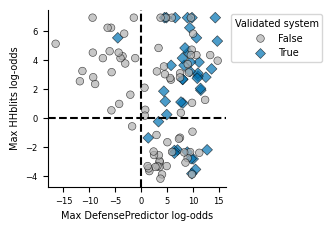

In [25]:
plt.subplots(figsize=(2.3,2.3))
sns.scatterplot(data=agg_df, x='max_dp_log_odds', y='max_hhblits_log_odds', hue='defensive',
                palette=['#B0B0B0', '#0072B2'], style='defensive', markers=["o", "D"],
                edgecolor='Black', alpha=0.7, s=30)
plt.ylabel('Max HHblits log-odds')
plt.xlabel('Max DefensePredictor log-odds')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Validated system')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hhblits_v_dp.svg', bbox_inches='tight', dpi=300)

In [26]:
agg_df.to_parquet('../data3/interim/all_cloned_tus.pq', index=False)

In [27]:
common_recall = np.linspace(0, 1, 45)

In [28]:
n_boot = 100
resampled_pr_list = list()
pr_list = list()
ap_list = list()
for method in ['max_dp_log_odds', 'max_hhblits_log_odds']:
    method_ap = metrics.average_precision_score(agg_df['defensive'], agg_df[method])
    method_ap_list = list()
    precision, recall, cutoff = metrics.precision_recall_curve(agg_df['defensive'], agg_df[method])
    pr_list.append(pd.DataFrame({'precision': precision, 
                                 'recall': recall, 
                                 'method': method}))
    for boot in tqdm(range(n_boot)):
        resampled_agg_df = agg_df.sample(frac=1, replace=True, random_state=boot)
        precision, recall, cutoff = metrics.precision_recall_curve(resampled_agg_df['defensive'], resampled_agg_df[method])
        interp_precision = interpolate_precision(common_recall, precision, recall)
        resampled_pr_df = (pd.DataFrame({'precision': interp_precision, 
                               'recall': common_recall}))
        resampled_pr_df['method'] = method
        resampled_pr_df['boot'] = boot
        resampled_pr_list.append(resampled_pr_df)
        method_ap_list.append(metrics.average_precision_score(resampled_agg_df['defensive'], resampled_agg_df[method]))
    ap_list.append({'method': method, 
                    'AP': method_ap,
                    'AP_std': np.std(method_ap_list)})
ap_df = pd.DataFrame(ap_list)
ap_df['display_name'] = (ap_df['method'].map({'max_dp_log_odds': 'DefensePredictor', 'max_hhblits_log_odds': 'HHblits'}) + 
                         ' (AP = ' + ap_df['AP'].round(3).astype(str) + ' ± ' + ap_df['AP_std'].round(3).astype(str) + ')')
cat_resampled_pr_df = pd.concat(resampled_pr_list)
merged_resampled_pr_df = (cat_resampled_pr_df.merge(ap_df, how='inner', 
                                on='method'))
merged_pr_df = (pd.concat(pr_list)
                .merge(ap_df, how='inner', on='method'))

100%|██████████| 100/100 [00:01<00:00, 84.81it/s]


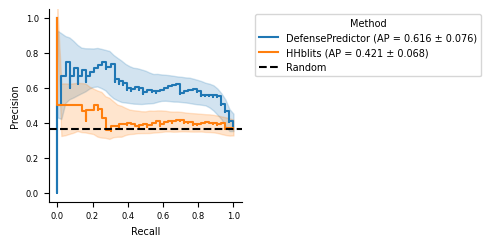

In [29]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
metrics.PrecisionRecallDisplay.from_predictions(agg_df['defensive'], agg_df['max_dp_log_odds'], ax=ax, 
                                                label=ap_df.loc[ap_df['method'] == 'max_dp_log_odds', 'display_name'].squeeze())
metrics.PrecisionRecallDisplay.from_predictions(agg_df['defensive'], agg_df['max_hhblits_log_odds'], ax=ax, 
                                                label=ap_df.loc[ap_df['method'] == 'max_hhblits_log_odds', 'display_name'].squeeze())
plt.axhline(y=agg_df['defensive'].mean(), color='black', label='Random', linestyle='dashed')
sns.lineplot(data=merged_resampled_pr_df, 
              x='recall', y='precision', errorbar='sd', estimator='mean',
              hue='display_name', drawstyle='steps-pre', alpha=0, legend=False)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05,1.05)
sns.despine()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title='Method')
plt.savefig('../figures/hhblits_v_dp_pr_curve.svg', bbox_inches='tight', dpi=300)

In [30]:
agg_df['defensive'].mean()

0.3644067796610169

## Plot hit

In [85]:
hit_df = pd.read_csv('../data3/raw/Negative EOP tracking - Systems.csv')

In [86]:
phage_order = ['T5', 'Bas26', 
               'Candy', 'RB69', 'T4', 
               'Bas63', 
               'Bas60', 
               'Bas50', 
               'Bas69', 
               'Bas67', 'T3', 'T7', 
               'Lambda', 
               'SECphi17', 
               'Bas19', 'Bas25', 'Bas21', 
               'SECphi18', 
               'Bas1', 'Bas3', 'Bas11', 'Bas9', 'Bas6', 'SECphi27']

In [87]:
hit_df['-log(EOP)'] = [0 if x < 0.5 else x for x in hit_df['-log(EOP)'] ]
hit_df['Phage'] = pd.Categorical(hit_df['Phage'], categories=phage_order)
hit_df['smaller_plaque'] = ((hit_df['Smaller Plaque Size'] == 'Y') & (hit_df['-log(EOP)'] < 1))
hit_df['hit'] = True

In [114]:
wide_hit_df = hit_df.pivot(columns='Phage', index='System', values='-log(EOP)').fillna(0)
wide_hit_annot = (hit_df.pivot(columns='Phage', index='System', values='smaller_plaque')
                  .fillna(False).applymap(lambda x: 's' if x else ''))

In [115]:
sys_height = 0.25

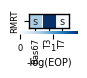

In [116]:
fig, ax = plt.subplots(figsize=(sys_height*wide_hit_df.shape[1], sys_height*len(wide_hit_df)))
sns.heatmap(wide_hit_df,  
            linecolor='#F2F2F2', linewidth=0.5,
            ax=ax, cmap='Blues', cbar=True, 
            cbar_kws={#'shrink': 2, 
                      "orientation": "horizontal",
                      'label': '-log(EOP)'}, 
            square=True)
sns.heatmap(wide_hit_df,  
            linecolor='#F2F2F2', linewidth=0.5,
            ax=ax, cmap='Blues', 
            annot=wide_hit_annot, fmt="", cbar=False)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)  # Adjust border thickness if necessary
plt.savefig('../figures/neg_hit_heatmap.svg', dpi=300, bbox_inches='tight')

In [94]:
system_df = negative_tus[negative_tus['defensive']]

In [96]:
domain_df = pd.read_csv('../data3/raw/HHPred negatives - hhpred_domains.csv')

In [110]:
def plot_system(system_df, cat_domains, show_scale=True, show_prob_cmap=False, 
                hhpred_cmap=None, sys_height=sys_height, clip_on=False):
    sys_height += -0.05
    if hhpred_cmap is None:
        hhpred_cmap = sns.color_palette("light:#E8020B", as_cmap=True)
    total_length = system_df['product_length'].sum() + 3*len(system_df)
    fig, ax = plt.subplots(figsize=(3.9, sys_height))
    ax.set_clip_on(clip_on)
    x_offset = 0
    if system_df['strand'].to_list()[0] == '-':
        system_df = system_df.sort_values('start', ascending=False).reset_index(drop=True)
    else:
        system_df = system_df.sort_values('start', ascending=True).reset_index(drop=True)
    for _, protein_series in system_df.iterrows():
        product_accession = protein_series['product_accession']
        protein_length = protein_series['product_length']
        protein_edgecolor = 'black'
        # plot individual domains
        domain_df = cat_domains[cat_domains['product_accession'] == product_accession]
        for _, domain_series in domain_df.iterrows():
            textcolor='black'
            start = domain_series['start']
            end = domain_series['end']
            label = domain_series['Domain Name']
            probability = domain_series['Domain Prob']
            if not pd.isnull(probability):
                color = hhpred_cmap(probability)                   
            else:
                color = 'darkgrey'
            domain_rect = patches.Rectangle((x_offset + start, -3), end - start, 6, facecolor=color, linewidth=0, clip_on=clip_on)
            ax.add_patch(domain_rect)
            ax.text(x_offset + ((start + end) / 2), -0.3, label, ha='center', va='center', fontdict={'color': textcolor})
        arrow_width = 6
        protein_arrow = patches.FancyArrow(x_offset, 0, protein_length, 0, 
                                           width=arrow_width, facecolor='none', edgecolor=protein_edgecolor, linewidth=1, 
                                           length_includes_head=True, head_width=arrow_width, head_length=0.05*total_length, 
                                           clip_on=clip_on)
        ax.add_patch(protein_arrow)
        #if protein_series['df_q_cov'] > 0.5:
        #    ax.text(x_offset + protein_length - 0.02*total_length, 2.8, '*', ha='center', va='center', fontdict={'color': 'black'})
        x_offset += protein_length + 1
    ax.axis('off')
    if show_scale: 
        ax.hlines(-4, 0, 100, linewidth=1, color='black', zorder=0, clip_on=clip_on)
    if show_prob_cmap:
        # Add a colorbar legend
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="150%", )
        norm = plt.Normalize(0, 1)
        cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=hhpred_cmap), cax=cax, orientation='horizontal', 
                          fraction=0.046, pad=0.04)
        cb.set_label("HHPred Probability")

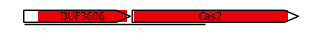

In [111]:
plot_system(system_df, domain_df)
plt.savefig('../figures/RMRT.svg', dpi=300, bbox_inches='tight')